In [36]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
import os
import random
import warnings
warnings.filterwarnings('ignore')

base_feats = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum']

## 1. 데이터 로딩

data_dir = '/opt/ml/input/data' # 경로
train_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터
test_file_path = os.path.join(data_dir, 'test_data.csv')
df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)
df_test = df_test[df_test.answerCode!=-1]  # answer_code -1 제외
df_train.shape, df_test.shape

((2266586, 6), (259370, 6))

In [60]:
day_dict_rev={
    6: 'Sunday',
    2: 'Monday',
    0: 'Tuesday',
    5: 'Wednesday',
    1: 'Thursday',
    4: 'Friday',
    3: 'Saturday',
}

In [37]:
day_dict = {'Tuesday': 0,
 'Thursday': 1,
 'Monday': 2,
 'Saturday': 3,
 'Friday': 4,
 'Wednesday': 5,
 'Sunday': 6}
def feature_engineering(df):
    df2 = df.copy()
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df2['user_correct_answer'] = df2.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df2['user_total_answer'] = df2.groupby('userID')['answerCode'].cumcount()
    df2['user_acc'] = df2['user_correct_answer']/df2['user_total_answer']
    df2['month'] = pd.to_datetime(df2.Timestamp).dt.month
    df2['day'] = pd.to_datetime(df2.Timestamp).dt.day
    df2['hour'] = pd.to_datetime(df2.Timestamp).dt.hour
    df2['dayname'] = pd.to_datetime(df2.Timestamp).dt.day_name().map(day_dict)
    df2['big_category'] = df2.testId.map(lambda x:x[2]).astype(int)
    df2['problem_num'] = df2.assessmentItemID.map(lambda x: int(x[-3:]))
    df2['mid_category'] = df2.testId.map(lambda x: int(x[-3:]))

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df2.groupby(['testId'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_t.columns = ["test_mean", "test_std", 'test_sum']
    correct_k = df2.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_std', 'tag_sum']

    df2 = pd.merge(df2, correct_t, on=['testId'], how="left")
    df2 = pd.merge(df2, correct_k, on=['KnowledgeTag'], how="left")
    
    return df2

train_fe = feature_engineering(df_train)
test_fe = feature_engineering(df_test)
train_fe.shape, test_fe.shape

((2266586, 22), (259370, 22))

## Riiid CV Strategy
- Second Solution
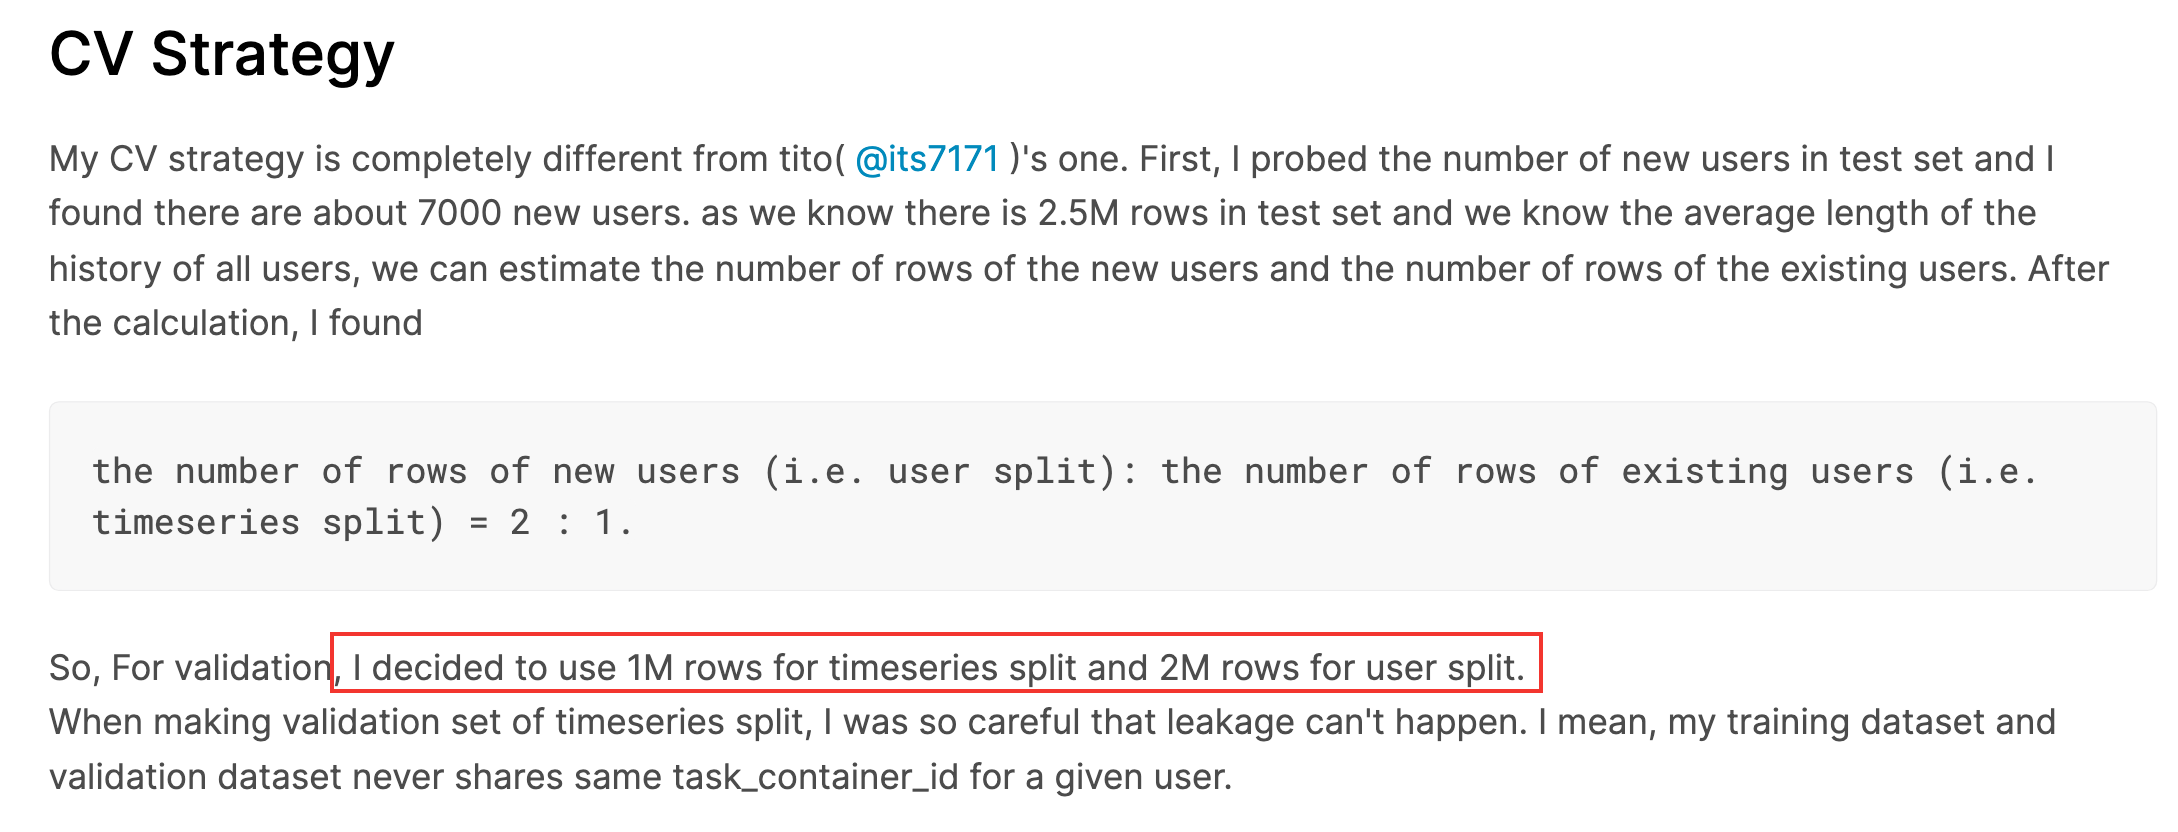
출처: https://www.kaggle.com/competitions/riiid-test-answer-prediction/discussion/210113
        
tito(grandmaster)의 또다른 CV Strategy: https://www.kaggle.com/code/its7171/cv-strategy/notebook
CV Discussion: https://www.kaggle.com/competitions/riiid-test-answer-prediction/discussion/192919

## train과 test timeseries 보기

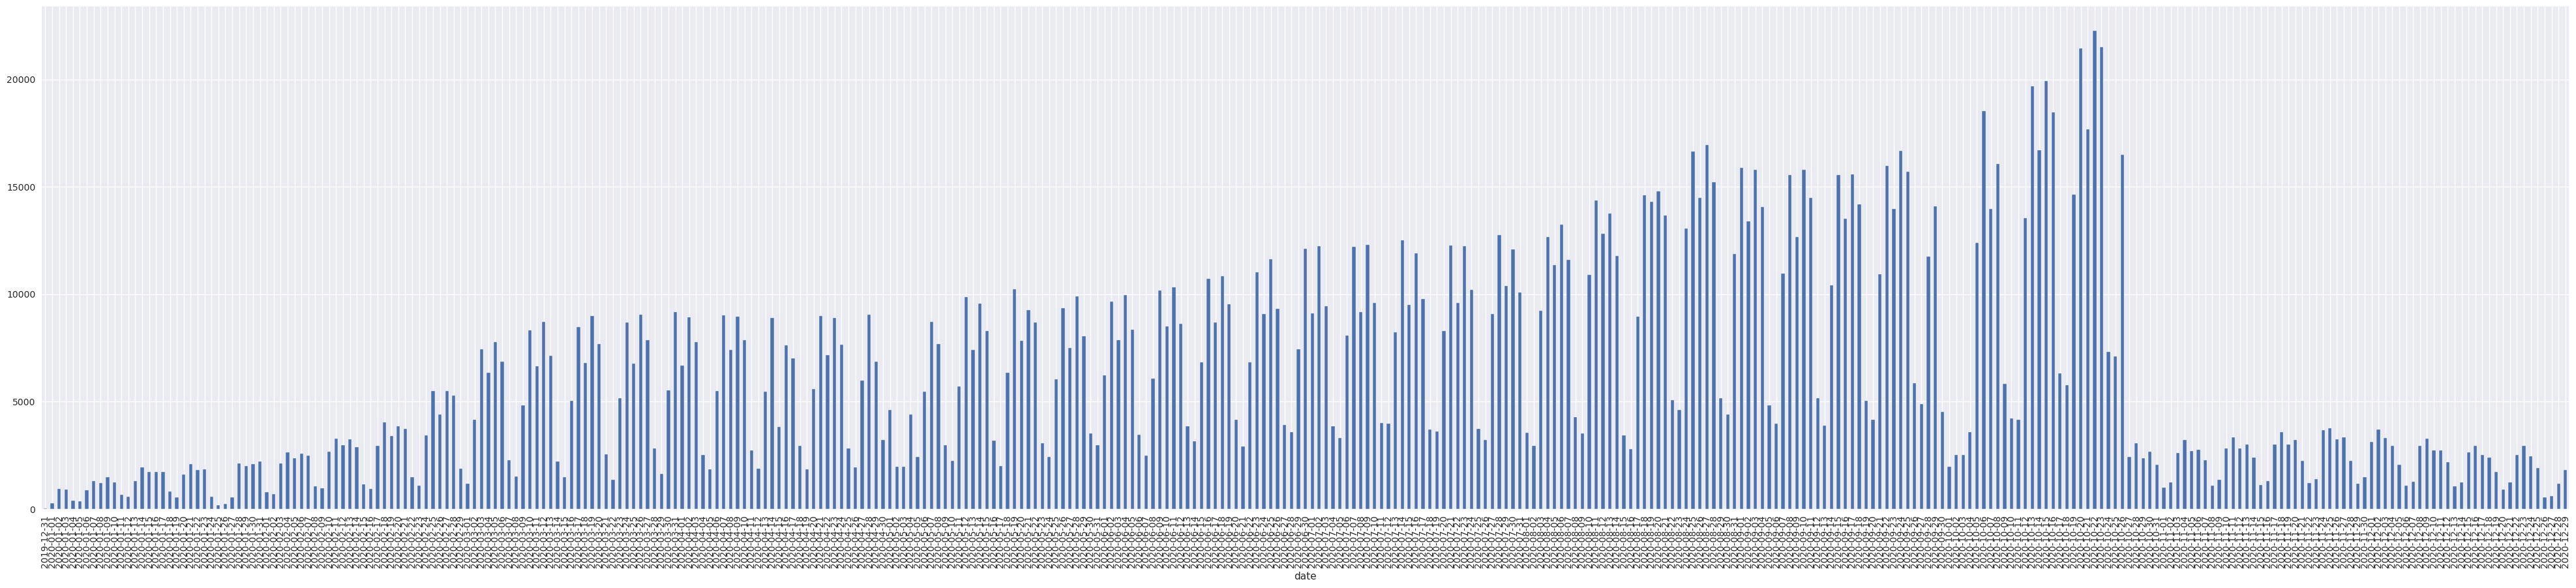

In [38]:
time_df = train_fe.copy()
# time_df['date'] = time_df['Timestamp'].astype("datetime64").dt.date
time_df['date'] = pd.to_datetime(time_df['Timestamp']).dt.date
df_gb = time_df.groupby(['date']).size()
q = plt.figure(figsize=(50,10))
q = df_gb.plot(kind = 'bar')

In [39]:
sorted(time_df.date.unique())[:10]
sorted(time_df.date.unique())[-10:]

[datetime.date(2019, 12, 31),
 datetime.date(2020, 1, 1),
 datetime.date(2020, 1, 2),
 datetime.date(2020, 1, 3),
 datetime.date(2020, 1, 4),
 datetime.date(2020, 1, 5),
 datetime.date(2020, 1, 6),
 datetime.date(2020, 1, 7),
 datetime.date(2020, 1, 8),
 datetime.date(2020, 1, 9)]

[datetime.date(2020, 12, 20),
 datetime.date(2020, 12, 21),
 datetime.date(2020, 12, 22),
 datetime.date(2020, 12, 23),
 datetime.date(2020, 12, 24),
 datetime.date(2020, 12, 25),
 datetime.date(2020, 12, 26),
 datetime.date(2020, 12, 27),
 datetime.date(2020, 12, 28),
 datetime.date(2020, 12, 29)]

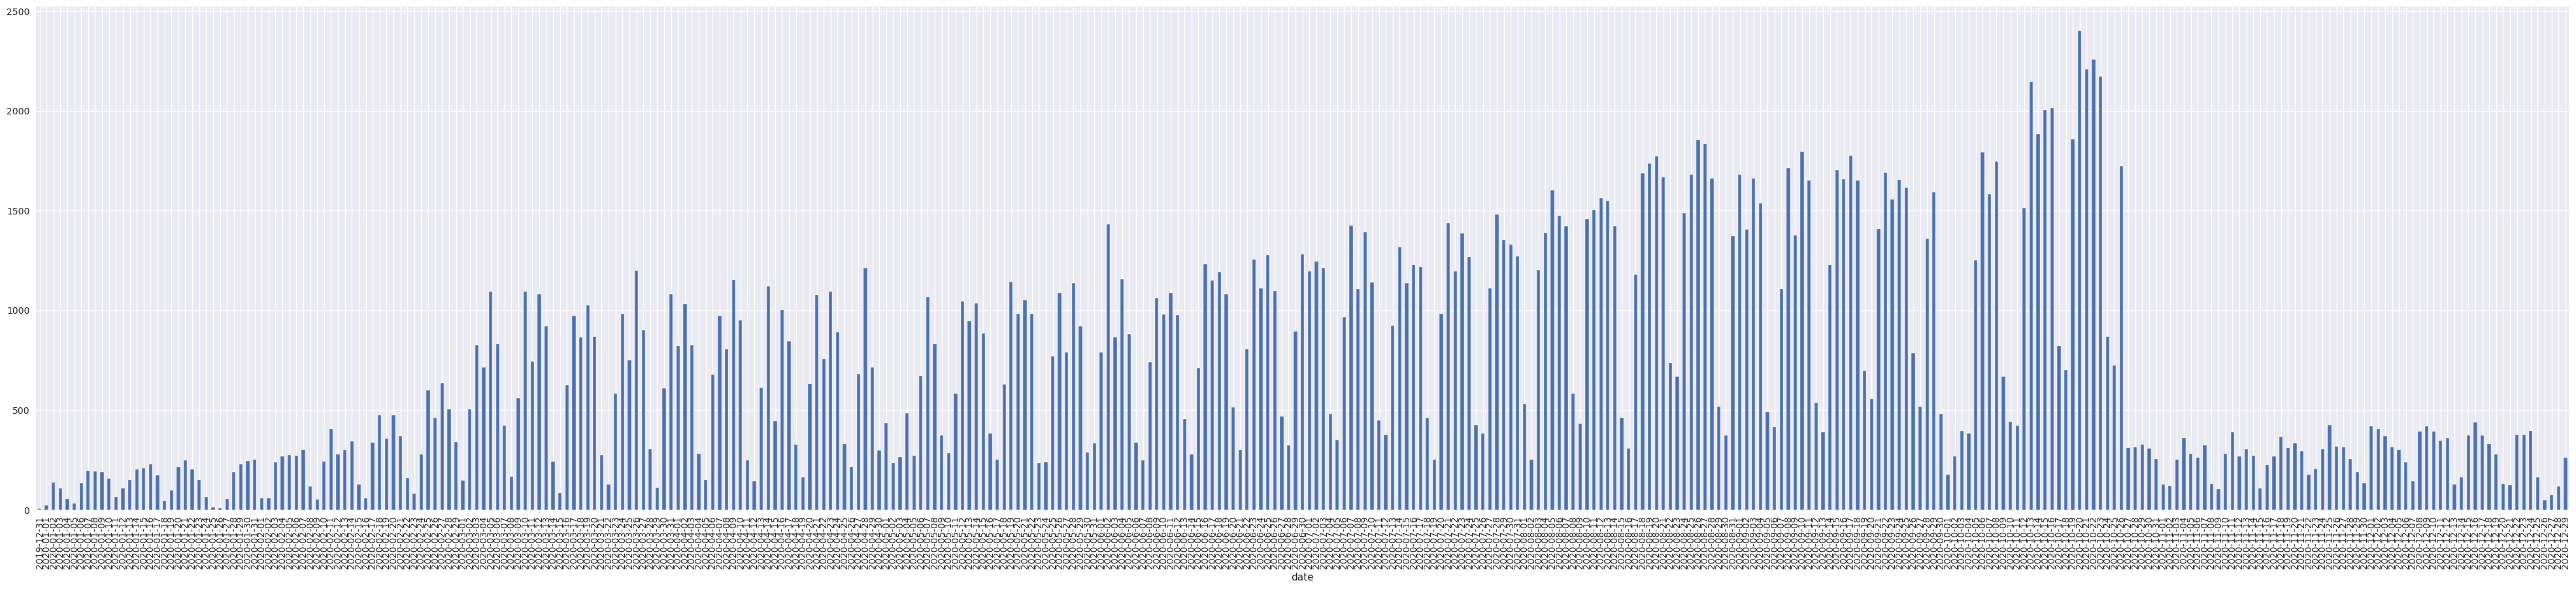

In [40]:
time_df2 = test_fe.copy()
# time_df['date'] = time_df['Timestamp'].astype("datetime64").dt.date
time_df2['date'] = pd.to_datetime(time_df2['Timestamp']).dt.date
df_gb2 = time_df2.groupby(['date']).size()
q = plt.figure(figsize=(50,10))
q = df_gb2.plot(kind = 'bar')

In [41]:
sorted(time_df2.date.unique())[:10]
sorted(time_df2.date.unique())[-10:]

[datetime.date(2019, 12, 31),
 datetime.date(2020, 1, 1),
 datetime.date(2020, 1, 2),
 datetime.date(2020, 1, 3),
 datetime.date(2020, 1, 4),
 datetime.date(2020, 1, 5),
 datetime.date(2020, 1, 6),
 datetime.date(2020, 1, 7),
 datetime.date(2020, 1, 8),
 datetime.date(2020, 1, 9)]

[datetime.date(2020, 12, 20),
 datetime.date(2020, 12, 21),
 datetime.date(2020, 12, 22),
 datetime.date(2020, 12, 23),
 datetime.date(2020, 12, 24),
 datetime.date(2020, 12, 25),
 datetime.date(2020, 12, 26),
 datetime.date(2020, 12, 27),
 datetime.date(2020, 12, 28),
 datetime.date(2020, 12, 29)]

### 정답률

### timeseries 정답률

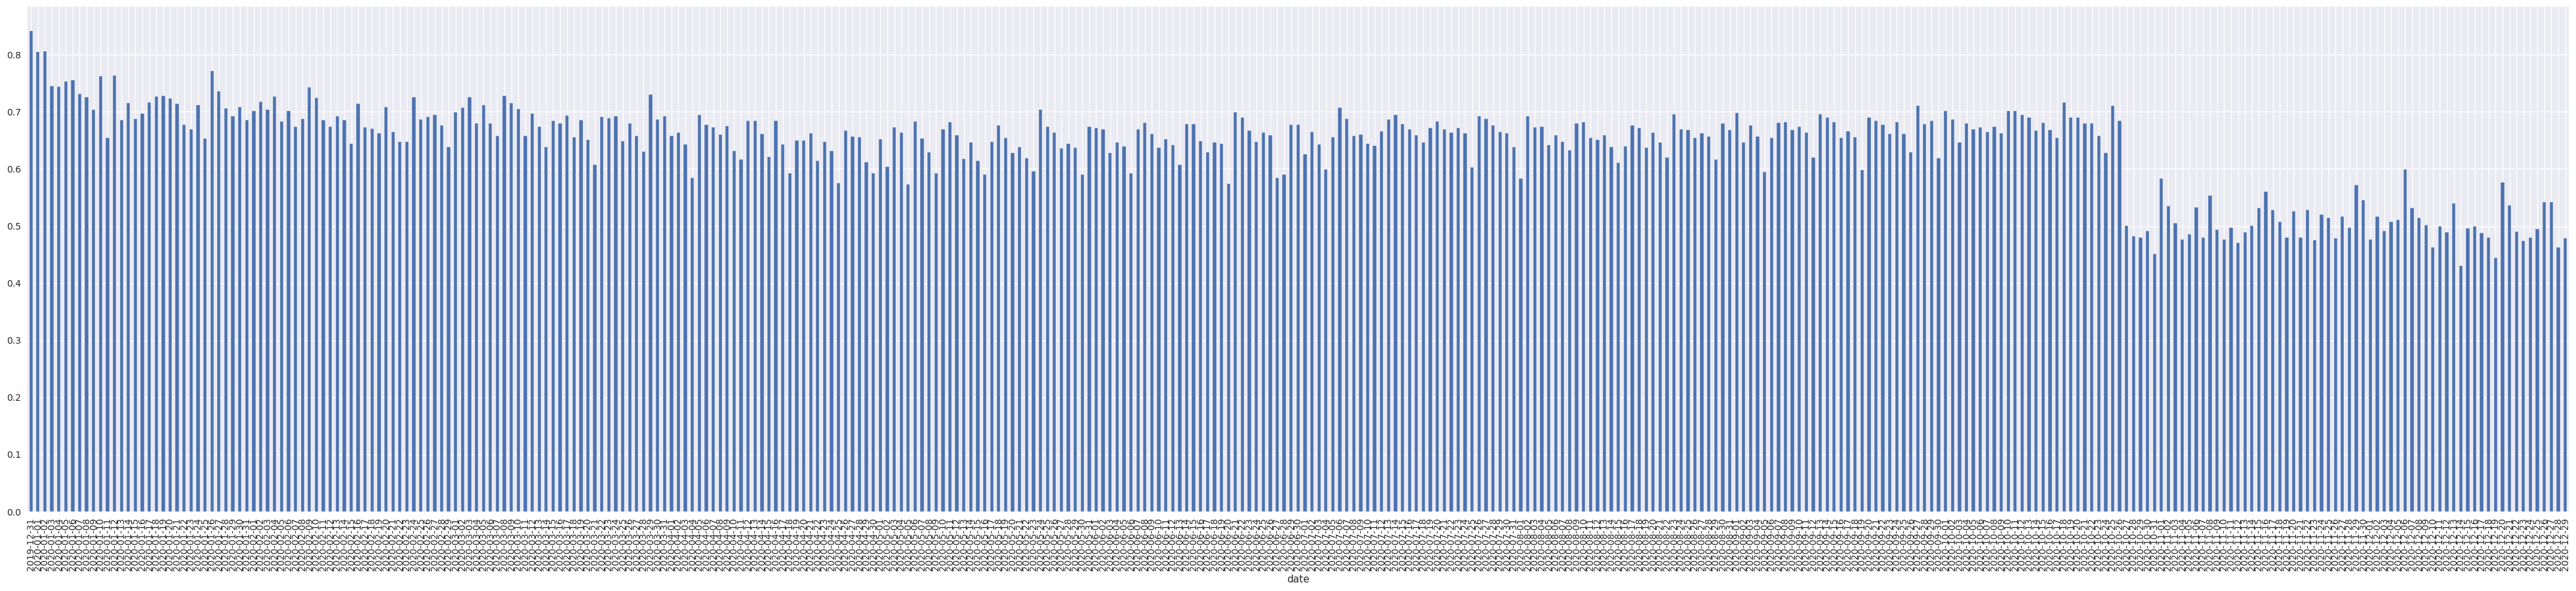

In [42]:
q = plt.figure(figsize=(50,10))
q = time_df.groupby('date')['answerCode'].mean().plot(kind = 'bar')

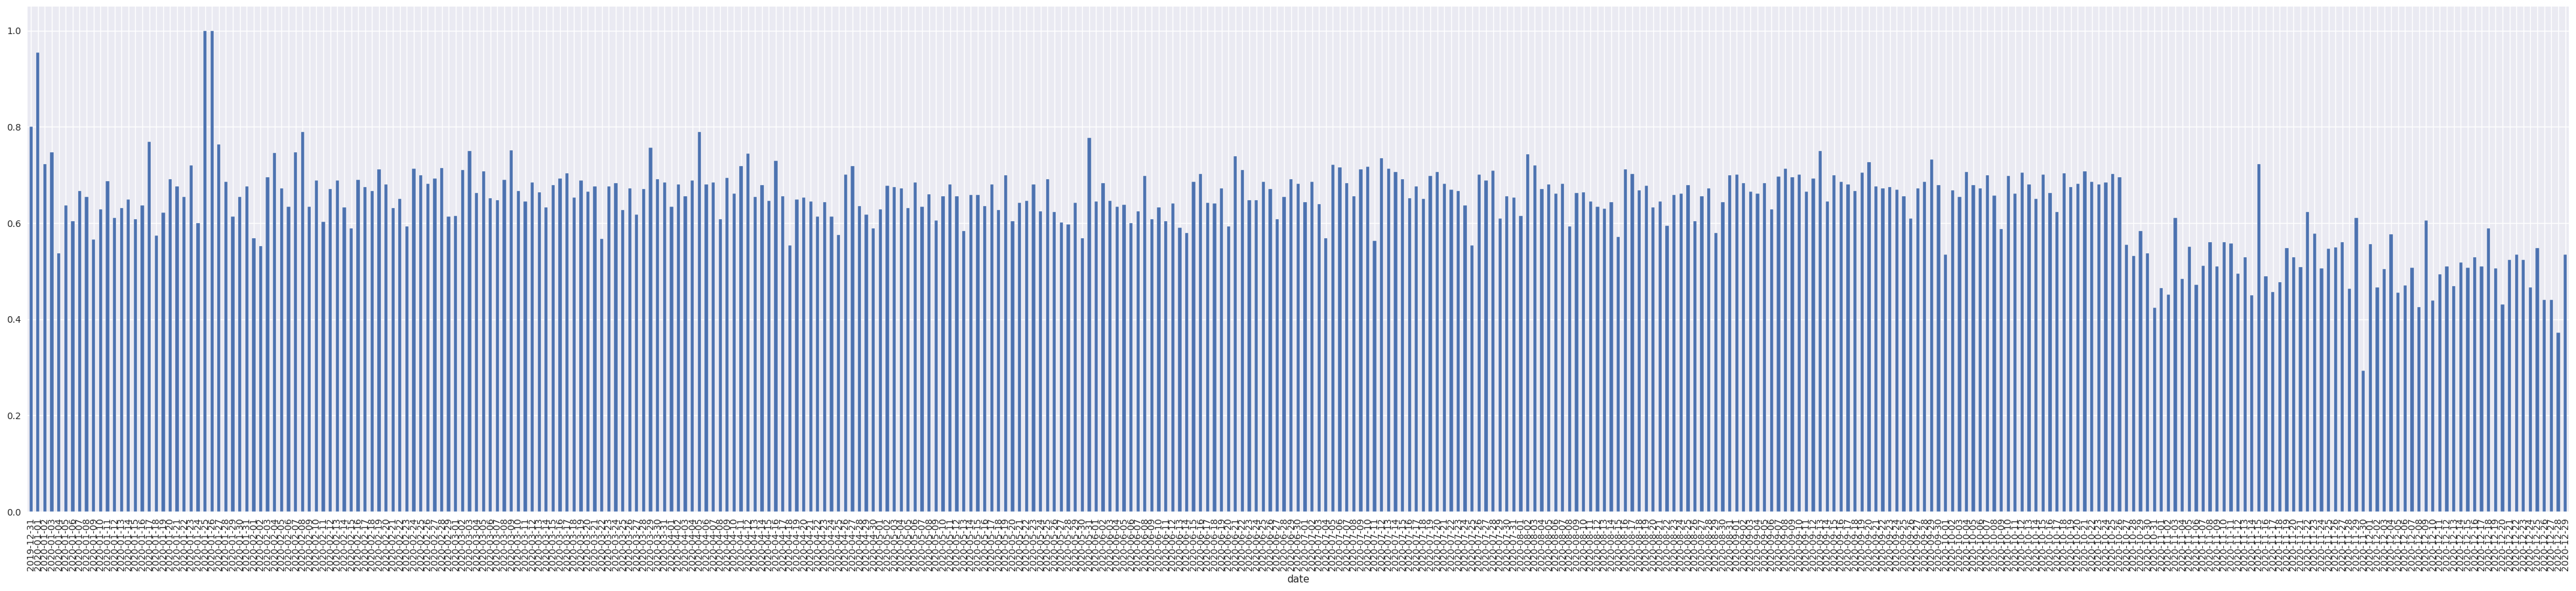

In [43]:
q = plt.figure(figsize=(50,10))
q = time_df2.groupby('date')['answerCode'].mean().plot(kind = 'bar')

### 요일별 정답률

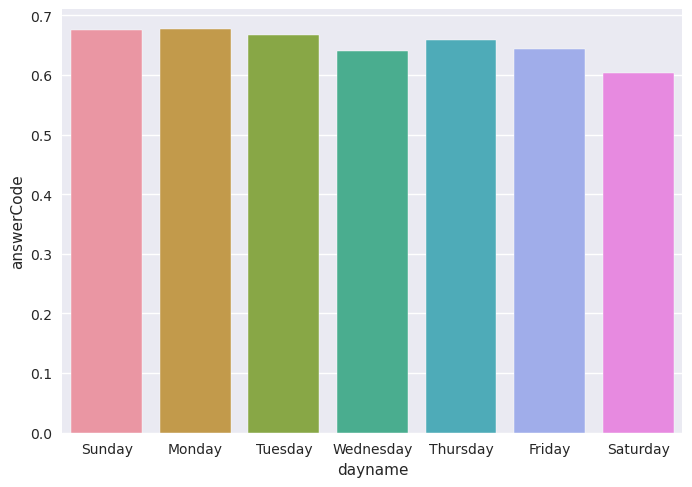

In [87]:
df = time_df.groupby('dayname')['answerCode'].mean().reset_index()
df['dayname'] = df.dayname.map(day_dict_rev)

interest_li = ['Sunday', 'Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday','Saturday']
df_sort = df[df['dayname'].isin(interest_li)].copy() # 먼저, 데이터 프레임에서 관심값 추출
sorterIndex = dict(zip(interest_li, range(len(interest_li)))) # 정렬을 위한 dictionary 생성
df_sort['sorter'] = df_sort['dayname'].map(sorterIndex) # 해당 dictionary를 이용해 정렬을 위한 열('sorter') 생성
df_sort.sort_values('sorter',inplace=True) # sorter를 기준으로 정렬
df_sort.drop('sorter', 1, inplace = True) # sorter 열 삭제
df_sort.reset_index(drop=True,inplace=True)

q = sns.barplot(df_sort, x='dayname', y='answerCode')

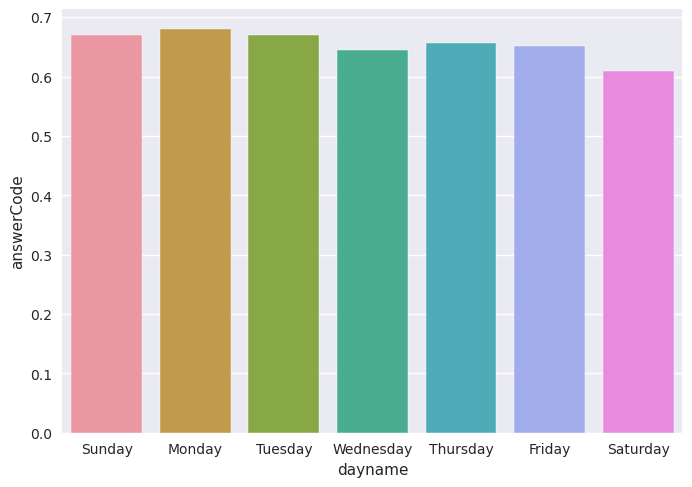

In [85]:
df = time_df2.groupby('dayname')['answerCode'].mean().reset_index()
df['dayname'] = df.dayname.map(day_dict_rev)

interest_li = ['Sunday', 'Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday','Saturday']
df_sort = df[df['dayname'].isin(interest_li)].copy() # 먼저, 데이터 프레임에서 관심값 추출
sorterIndex = dict(zip(interest_li, range(len(interest_li)))) # 정렬을 위한 dictionary 생성
df_sort['sorter'] = df_sort['dayname'].map(sorterIndex) # 해당 dictionary를 이용해 정렬을 위한 열('sorter') 생성
df_sort.sort_values('sorter',inplace=True) # sorter를 기준으로 정렬
df_sort.drop('sorter', 1, inplace = True) # sorter 열 삭제
df_sort.reset_index(drop=True,inplace=True)

q = sns.barplot(df_sort, x='dayname', y='answerCode')

In [116]:
train_ab = time_df[time_df.date.map(str)=='2020-11-15']
train_ab.groupby('userID')['answerCode'].agg(['count','mean','std'])

,count,mean,std
userID,,,
24,8,0.250000,0.462910
31,9,1.000000,0.000000
39,7,1.000000,0.000000
48,8,0.625000,0.517549
61,8,1.000000,0.000000
96,8,0.500000,0.534522
117,8,1.000000,0.000000
132,8,0.250000,0.462910
143,14,0.571429,0.513553


In [118]:
test_ab = time_df2[time_df2.date.map(str)=='2020-11-15']
test_ab.groupby('userID')['answerCode'].agg(['count','mean','std'])

,count,mean,std
userID,,,
4,8,0.625000,0.517549
79,11,1.000000,0.000000
193,8,0.750000,0.462910
361,7,0.285714,0.487950
414,8,1.000000,0.000000
617,16,0.500000,0.516398
802,14,1.000000,0.000000
1503,8,0.875000,0.353553
1828,6,0.666667,0.516398


## 유저별 그룹화